In [1]:
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
import pandas as pd

# Load the dataset
annotations = "2021/rater1_annotations.txt"
df_data = pd.read_csv(annotations, delimiter=";")

df_data

,image_url,user_scores
0,./PANA_210706/1343_1.JPG,8
1,./PANA_210706/1343_2.JPG,6
2,./PANA_210706/1343_3.JPG,5
3,./PANA_210706/1344_1.JPG,4
4,./PANA_210706/1344_2.JPG,4
...,...,...
1590,./NIKON_210706/1089_2.JPG,7
1591,./NIKON_210706/1089_3.JPG,6
1592,./NIKON_210706/1689_1.JPG,5
1593,./NIKON_210706/1689_2.JPG,5


In [4]:
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


# Adding address prefix to each image URL
address_prefix = "2021/Images"

# Modify the first column (remove first character and add prefix)
df_data.iloc[:, 0] = df_data.iloc[:, 0].astype(str).str[1:]  # Remove first character
df_data.iloc[:, 0] = address_prefix + df_data.iloc[:, 0]  # Add address prefix
df_data.iloc[:, 1] = df_data.iloc[:, 1].apply(lambda x: 0 if x <= 4 else 1)

# Display modified DataFrame
print(df_data)





                                image_url  user_scores
0      2021/Images/PANA_210706/1343_1.JPG            1
1      2021/Images/PANA_210706/1343_2.JPG            1
2      2021/Images/PANA_210706/1343_3.JPG            1
3      2021/Images/PANA_210706/1344_1.JPG            0
4      2021/Images/PANA_210706/1344_2.JPG            0
...                                   ...          ...
1590  2021/Images/NIKON_210706/1089_2.JPG            1
1591  2021/Images/NIKON_210706/1089_3.JPG            1
1592  2021/Images/NIKON_210706/1689_1.JPG            1
1593  2021/Images/NIKON_210706/1689_2.JPG            1
1594  2021/Images/NIKON_210706/1689_3.JPG            0

[1595 rows x 2 columns]


In [12]:
# Set image size
img_size = 224
images = []
labels = df_data.iloc[:, 1].values  # Assuming second column has labels/scores

# Read and resize images
for f in df_data.iloc[:, 0]:
    im = cv2.imread(f)
    if im is not None:  # Ensure the image is loaded correctly
        im = cv2.resize(im, (img_size, img_size))
        images.append(im)
    else:
        print(f"Warning: Could not load image {f}")

# Convert to NumPy array
images = np.array(images)


In [13]:
# Perform Label Encoding (Convert labels to numerical values)
# label_encoder = LabelEncoder()
# labels_encoded = label_encoder.fit_transform(labels)



# Perform One-Hot Encoding
labels_encoded = labels.reshape(-1, 1)  # Reshape for OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
labels_one_hot = one_hot_encoder.fit_transform(labels_encoded)


In [14]:
# Train-Test-Eval Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)  # 80% Train


# Print dataset shapes
print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)



Train set: (1276, 224, 224, 3) (1276, 2)
Test set: (319, 224, 224, 3) (319, 2)


## EfficientNet Implemenation ##

In [19]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

NUM_CLASSES = 2
IMG_SIZE = 224
size = (IMG_SIZE, IMG_SIZE)

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

outputs = EfficientNetB0(include_top=True, weights = None, classes = NUM_CLASSES)(inputs)

In [20]:
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"] )

model.summary()

hist = model.fit(X_train, y_train, epochs=20, verbose=2)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 2)                   │       4,052,133 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 4,010,110 (15.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/20
40/40 - 165s - 4s/step - accuracy: 0.5658 - loss: 2.7772
Epoch 2/20
40/40 - 105s - 3s/step - accuracy: 0.5854 - loss: 1.7058
Epoch 3/20
40/40 - 102s - 3s/step - accuracy: 0.5580 - loss: 1.9757
Epoch 4/20
40/40 - 122s - 3s/step - accuracy: 0.6074 - loss: 0.9923
Epoch 5/20
40/40 - 107s - 3s/step - accuracy: 0.6215 - loss: 0.9922
Epoch 6/20
40/40 - 102s - 3s/step - accuracy: 0.6528 - loss: 1.0016
Epoch 7/20
40/40 - 101s - 3s/step - accuracy: 0.6654 - loss: 0.8747
Epoch 8/20
40/40 - 100s - 3s/step - accuracy: 0.7273 - loss: 0.7255
Epoch 9/20
40/40 - 100s - 2s/step - accuracy: 0.7837 - loss: 0.6797
Epoch 10/20
40/40 - 100s - 3s/step - accuracy: 0.7900 - loss: 0.6244
Epoch 11/20
40/40 - 99s - 2s/step - accuracy: 0.8723 - loss: 0.5659
Epoch 12/20
40/40 - 99s - 2s/step - accuracy: 0.8864 - loss: 0.4724
Epoch 13/20
40/40 - 99s - 2s/step - accuracy: 0.9114 - loss: 0.3902
Epoch 14/20
40/40 - 102s - 3s/step - accuracy: 0.9373 - loss: 0.2419
Epoch 15/20
40/40 - 100s - 2s/step - accuracy:

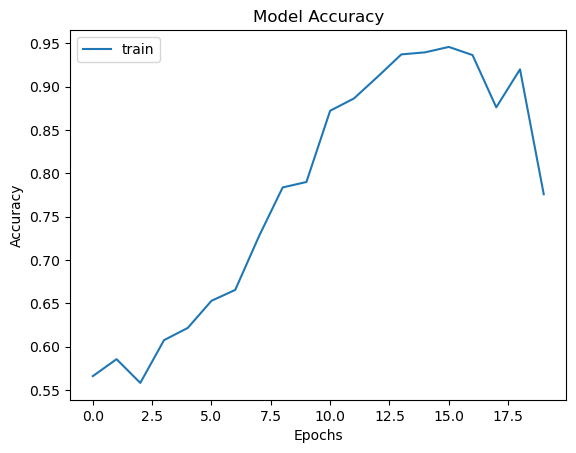

In [48]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend(["train", "test", "eval"], loc = "upper left")
    plt.savefig("hist.png", dpi=300, bbox_inches='tight')
    plt.show()

plot_hist(hist)

In [25]:
preds = model.evaluate(X_test, y_test)
print("Loss = " + str(preds[0]))
print("Test Accuracy = " + str(preds[1]))

10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 474ms/step - accuracy: 0.6825 - loss: 0.8889
Loss = 0.9153725504875183
Test Accuracy = 0.6896551847457886


In [ ]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [34]:
y_pred = model.predict(X_test)  # Predict probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class labels
y_pred_classes.shape
y_test_classes = np.argmax(y_test, axis=1)


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 493ms/step


In [38]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:\n", cm)

print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes))


Confusion Matrix:
 [[ 14  96]
 [  3 206]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.13      0.22       110
           1       0.68      0.99      0.81       209

    accuracy                           0.69       319
   macro avg       0.75      0.56      0.51       319
weighted avg       0.73      0.69      0.60       319



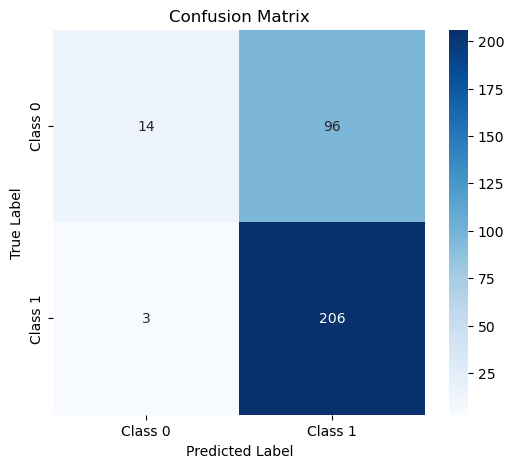

C:\Users\asus\Data Science\FHB_Project\confusion_matrix.png

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define class labels (modify if you have more classes)
class_labels = ["Class 0", "Class 1"]

# Create the confusion matrix plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Save the plot as an image
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# To download the image (works in Jupyter)
from IPython.display import FileLink
FileLink(r'confusion_matrix.png')


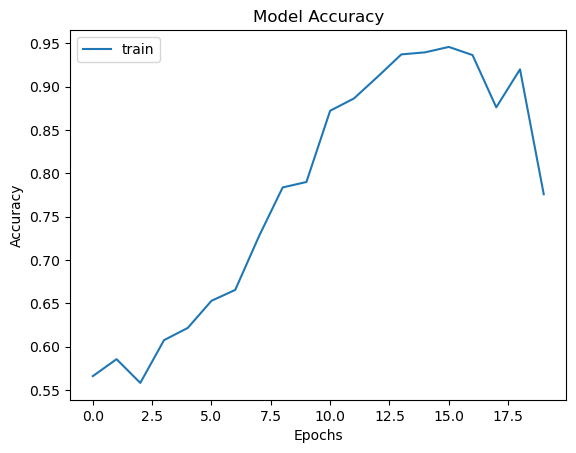

<Figure size 640x480 with 0 Axes>

In [44]:
plot_hist(hist)
plt.savefig("accuracy_vs_epochs.png", dpi=300, bbox_inches='tight')  # Save as PNG